In [27]:
## Adding the .simplify_full() command may give cleaner functions to look at, but drastically increases the runtime (from 0.5 sec to more than 4 min), and, most importantly, causes completely unstable computations that ruin the precision (for unknown reasons).

prec = 300
R = RealBallField(prec)
var('x')
assume(x, 'real')

W = (-x/2 + sqrt(1/27 + x^2/4))^(1/3) - (x/2 + sqrt(1/27 + x^2/4))^(1/3)
W_prime = diff(W, x)
a = 1 + W/x + W_prime
b = (3*x)/2 + W

# Number of derivatives to compute
n = 6

a_derivs = [a]
b_derivs = [b]

for k in range(1, n+1):
    a_deriv_k = diff(a, x, k)
    b_deriv_k = diff(b, x, k)
    a_derivs.append(a_deriv_k)
    b_derivs.append(b_deriv_k)

phi_0 = -a_derivs[0] + b_derivs[1]/2 + a_derivs[2]/2 - a_derivs[4]/2 + a_derivs[6]/2
phi_1 = -a_derivs[0] - b_derivs[1]/2 + 2*a_derivs[2] + b_derivs[3]/2 - 3*a_derivs[4] - b_derivs[5]/2
phi_2 = -a_derivs[0] - (3/2)*b_derivs[1] + (9/2)*a_derivs[2] + (5/2)*b_derivs[3]
phi_3 = -a_derivs[0] - (5/2)*b_derivs[1]
phi_list = [phi_0, phi_1, phi_2, phi_3]

# Base Fourier function
f = (1 + 4*pi*abs(x) + 4*pi^2*x^2) * exp(-2*pi*abs(x)) / 8

# Transformées inverses
lambda_1 = diff(f, x)
lambda_2 = -diff(f, x, 2)
lambda_3 = diff(f, x, 3)
lambda_4 = diff(f, x, 4)
lambda_list = [lambda_1,lambda_2,lambda_3,lambda_4]

In [28]:
# Convert symbolic functions to numerical ones evaluable on RealBallField elements
a_funcs = [fast_callable(expr, vars=[x], domain=R) for expr in a_derivs]
b_funcs = [fast_callable(expr, vars=[x], domain=R) for expr in b_derivs]
phi_funcs = [fast_callable(phi_expr, vars=[x], domain=R) for phi_expr in phi_list]
lambda_funcs = [fast_callable(lambda_expr, vars=[x], domain=R) for lambda_expr in lambda_list]

In [29]:
x0 = R(0.0000001)

print("Evaluations of the derivatives of a at x =",float(x0),":")
for k in range(n+1):
    a_val = a_funcs[k](x0)
    print(f"d^{k}a/dx^{k}({x0.center():.2f}) = {a_val}")

print("\nEvaluations of the derivatives of b at x =",float(x0),":")
for k in range(n+1):
    b_val = b_funcs[k](x0)
    print(f"d^{k}b/dx^{k}({x0.center():.2f}) = {b_val}")

Evaluations of the derivatives of a at x = 1e-07 :
d^0a/dx^0(0.00) = [-0.9999999999999600000000000018036201510538327734096467014763546719931198348083031765 +/- 5.32e-83]
d^1a/dx^1(0.00) = [7.99999999999927963798489466478781356336318243379863852354931829665960e-7 +/- 4.49e-76]
d^2a/dx^2(0.00) = [7.9999999999978400000000002881954881568813192278798700544731595979252 +/- 5.48e-68]
d^3a/dx^3(0.00) = [-4.3199999999988478045118432727850280473583233565051712000e-5 +/- 3.11e-61]
d^4a/dx^4(0.00) = [-431.9999999996544000000000924312781050894196521909402154 +/- 3.70e-53]
d^5a/dx^5(0.00) = [0.006911999999996303687218949931689972970847889 +/- 9.83e-46]
d^6a/dx^6(0.00) = [69119.9999998891200000000495431550587081822 +/- 4.86e-38]

Evaluations of the derivatives of b at x = 1e-07 :
d^0b/dx^0(0.00) = [5.000000000000099773740559126417717861617580175452365899614177843254289876015565019e-8 +/- 4.91e-90]
d^1b/dx^1(0.00) = [0.50000000000002999999999999849728488670963744709389787753271880572827060909019620315

In [39]:
def rigorous_max_partial_derivatives(f, x1, x2, y1, y2):
    var('x y')
    I_x = R(x1, x2)
    I_y = R(y1, y2)

    # dérivées partielles
    fx = diff(f, x)
    fy = diff(f, y)

    # Evaluation sur domaine 2D
    fx_eval = R(fx(x=I_x, y=I_y))
    fy_eval = R(fy(x=I_x, y=I_y))

    # Majoration de la valeur absolue
    fx_sup = R(max(abs(fx_eval.lower()), abs(fx_eval.upper())))
    fy_sup = R(max(abs(fy_eval.lower()), abs(fy_eval.upper())))

    return fx_sup, fy_sup

def riemann_integral(f_expr, x1, x2, y1, y2, n):
    
    var('x y')
    f_num = fast_callable(f_expr, vars=[x, y], domain=R)

    dx = (R(x2) - R(x1))/n
    dy = (R(y2) - R(y1))/n

    total = R(0)
    for i in range(n):
        for j in range(n):
            xi = R(x1) + i*dx
            yj = R(y1) + j*dy
            total += f_num(xi, yj) * dx * dy
        
        # Calcul du taux de complétion
        percent = int((i / n) * 100)
        sys.stdout.write(f"\rProgression : {percent}%")
        sys.stdout.flush()

    # Calcul des bornes sur les dérivées partielles
    max_fx, max_fy = rigorous_max_partial_derivatives(f_expr, x1, x2, y1, y2)

    # Calcul borne d'erreur théorique
    largeur = R(x2) - R(x1)
    hauteur = R(y2) - R(y1)
    error_bound = (largeur * hauteur / n) * (largeur * max_fx + hauteur * max_fy)
    return total ,error_bound

# Exemple d'utilisation
var('x y')
f_expr = x^3 + y^3
approx_integral ,error_bound = riemann_integral(f_expr, -1, 1, -1, 1, n=100)

print(f"\rApproximation de l'intégrale : {approx_integral}")
print(f"Borne d'erreur théorique (approx.) : {error_bound}")
print("L'intégrale est contenue dans l'intervalle [",float((approx_integral-error_bound).lower()) ,",",float((approx_integral+error_bound).upper()),"]")

Approximation de l'intégrale : [-0.08000000000000000000000000000000000000000000000000000000000000000000000000000000000000 +/- 5.41e-87]
Borne d'erreur théorique (approx.) : [1.92000001668930053710937500000000000000000000000000000000000000000000000000000000000000000 +/- 3.44e-90]
L'intégrale est contenue dans l'intervalle [ -2.0000000166893006 , 1.8400000166893007 ]


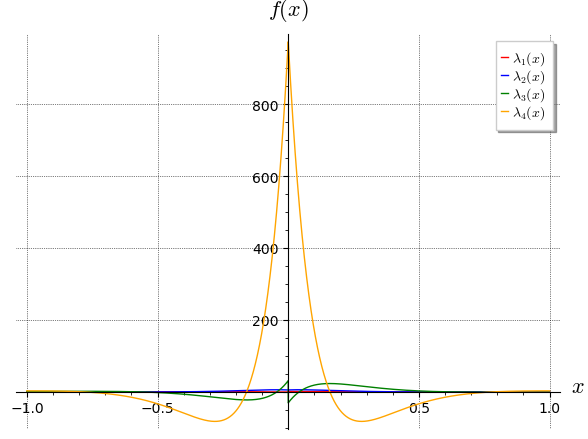

In [4]:
var('x')
assume(x, 'real')

# Fonction de base sur x >= 0
f_pos(x) = (1 + 4*pi*x + 4*pi^2*x^2) * exp(-2*pi*x) / 8

# Dérivées
f1 = diff(f_pos, x).simplify_full()
f2 = -diff(f_pos, x, 2).simplify_full()
f3 = diff(f_pos, x, 3).simplify_full()
f4 = diff(f_pos, x, 4).simplify_full()

# Création des fonctions rapides à partir des expressions symboliques
f1_fast = fast_callable(f1, vars=[x])
f2_fast = fast_callable(f2, vars=[x])
f3_fast = fast_callable(f3, vars=[x])
f4_fast = fast_callable(f4, vars=[x])

# Définition des fonctions par morceaux en utilisant les fonctions rapides
def lambda1(t):
    if t >= 0:
        return f1_fast(t)
    else:
        return -f1_fast(-t)

def lambda2(t):
    if t >= 0:
        return f2_fast(t)
    else:
        return f2_fast(-t)

def lambda3(t):
    if t >= 0:
        return f3_fast(t)
    else:
        return -f3_fast(-t)

def lambda4(t):
    if t >= 0:
        return f4_fast(t)
    else:
        return f4_fast(-t)

# Tracés
p1 = plot(lambda1, (x, -1, 1), color='red', legend_label=r'$\lambda_1(x)$')
p2 = plot(lambda2, (x, -1, 1), color='blue', legend_label=r'$\lambda_2(x)$')
p3 = plot(lambda3, (x, -1, 1), color='green', legend_label=r'$\lambda_3(x)$')
p4 = plot(lambda4, (x, -1, 1), color='orange', legend_label=r'$\lambda_4(x)$')

# Affichage combiné
show(p1 + p2 + p3 + p4, figsize=6, axes_labels=['$x$', '$f(x)$'], gridlines=True)
